# Squeeze and Excitation

Today’s experiment is based on the [Jie Hu, Li Shen, Gang Sun "Squeeze-and-Excitation Networks"](https://arxiv.org/abs/1709.01507).

We will compare the usual ResNet to ResNet with squeeze and excitation blocks.

To begin with let's figure out what SE block is.

It improves channel interdependencies at almost no computational cost. The main idea is to add the parameters to each channel of a convolutional block so that the network can adaptively adjust the weighting of each feature map.
 
<img src='_images/se_block.png'>

Let’s take a closer look at the structure of the block:

## __Squeeze block__
Firstly, each channel's feature maps are squeezed into a single numeric value. This results in a vector of size С, where С is the number of channels. 

<img src='_images/squeeze.png'>

## __Excitation block__
Afterwards, this value is fed through a tiny two-layer neural network, which outputs a vector of the same size C. These values can now be used as weights for the original feature maps, thus scaling each channel based on its importance.

<img src='_images/exictation.png'>

A more detailed explanation is presented in [the blog post on Medium](https://towardsdatascience.com/squeeze-and-excitation-networks-9ef5e71eacd7).

In [1]:
import sys

import numpy as np
import tensorflow as tf

from tqdm import tqdm_notebook as tqn
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

sys.path.append('../../..')
from batchflow import B, V
from batchflow.opensets import MNIST
from batchflow.models.tf import ResNet

sys.path.append('../../utils')
import utils

ImportError: Could not find 'cudart64_90.dll'. TensorFlow requires that this DLL be installed in a directory that is named in your %PATH% environment variable. Download and install CUDA 9.0 from this URL: https://developer.nvidia.com/cuda-toolkit

As always, let's create a dataset with MNIST data

In [2]:
dset = MNIST()

Extracting /tmp/t10k-images-idx3-ubyte.gz
ExtractingExtracting  /tmp/train-images-idx3-ubyte.gz/tmp/train-labels-idx1-ubyte.gz

Extracting /tmp/t10k-labels-idx1-ubyte.gz


We will use the standard [ResNet](https://analysiscenter.github.io/batchflow/api/batchflow.models.tf.resnet.html) from the BatchFlow models.

For comparison, we will create classic ResNet and ResNet with SE blocks. Both models have the same number of blocks. SE block is added to the model by specifying _True_ value for the key __'body/block/se_block'__ in the config as shown below.

In [3]:
ResNet_config = {
    'inputs':{'images': {'shape': (28, 28, 1)},
              'labels': {'classes': 10,
                         'transform': 'ohe',
                         'dtype': 'int32',
                         'name': 'targets'}},
    'input_block/inputs': 'images',
    'body/num_blocks': [1, 1, 1, 1],
    'body/filters': [64, 128, 256, 512],
    'body/block/bottleneck': True,
    'body/block/post_activation': tf.nn.relu,
    'body/block/layout': 'cna cna cn',
    'loss': 'ce',
    'optimizer': 'Adam',    
}

SE_config = {
    **ResNet_config, 
    'body/block/se_block': True,
}

Now create pipelines with the given configurations for a simple ResNet model

In [4]:
res_train_ppl = (dset.train.p
                 .init_model('dynamic',
                             ResNet,
                             'resnet',
                             config=ResNet_config)
                 .train_model('resnet',
                              feed_dict={'images': B('images'),
                                         'labels': B('labels')}))

res_test_ppl = (dset.test.p
                .init_variable('resloss', init_on_each_run=list)
                .import_model('resnet', res_train_ppl)
                .predict_model('resnet',
                               fetches='loss',
                               feed_dict={'images': B('images'),
                                          'labels': B('labels')},
                               save_to=V('resloss'), 
                               mode='a'))

And now the model with SE blocks

In [5]:
se_train_ppl = (dset.train.p
                .init_model('dynamic',
                            ResNet,
                            'se_block',
                            config=SE_config)
                .train_model('se_block',
                             feed_dict={'images': B('images'),
                                        'labels': B('labels')}))

se_test_ppl = (dset.test.p
               .init_variable('seloss', init_on_each_run=list)
               .import_model('se_block', se_train_ppl)
               .predict_model('se_block',
                              fetches='loss',
                              feed_dict={'images': B('images'),
                                         'labels': B('labels')},
                              save_to=V('seloss'), 
                              mode='a'))

After that, train our models

In [6]:
for i in tqn(range(500)):
    res_train_ppl.next_batch(300, n_epochs=None, shuffle=2)
    res_test_ppl.next_batch(300, n_epochs=None, shuffle=2)
    se_train_ppl.next_batch(300, n_epochs=None, shuffle=2)
    se_test_ppl.next_batch(300, n_epochs=None, shuffle=2)

Widget Javascript not detected.  It may not be installed or enabled properly.


It’s time to show the entire learning process

../../utils.py:44: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)
../../utils.py:45: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


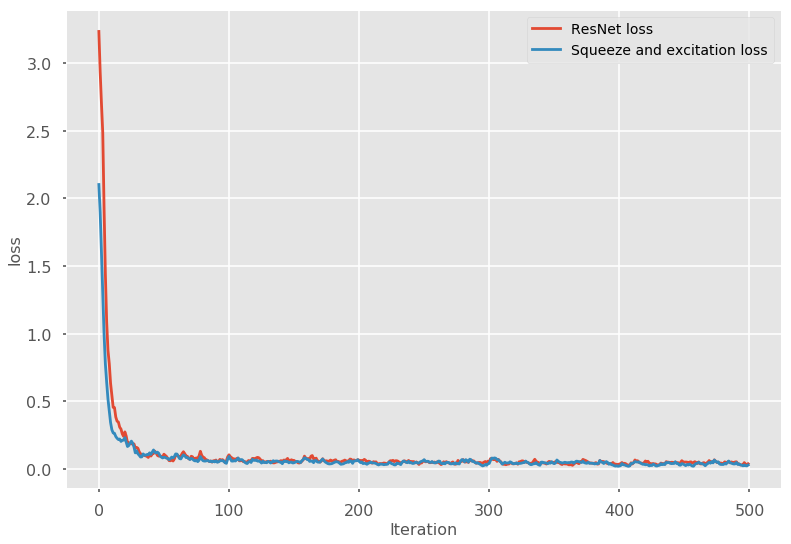

In [7]:
ResNet_loss = res_test_ppl.get_variable('resloss')
SE_loss = se_test_ppl.get_variable('seloss')
utils.draw(ResNet_loss, 'ResNet', SE_loss, 'Squeeze and excitation')

On this plot, it is very difficult to see the difference between them. Let’s look at the chart closer to see the last 200 iterations.

../../utils.py:44: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)
../../utils.py:45: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


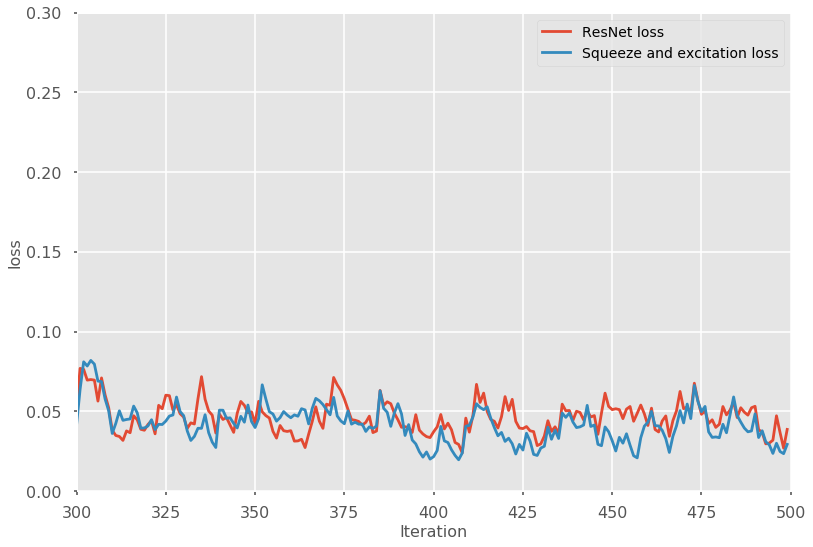

In [8]:
utils.draw(ResNet_loss, 'ResNet', SE_loss, 'Squeeze and excitation', bound=[300, 500, 0, 0.3])

Because of the large variance, it is again impossible to tell which model is better. We can try to smooth out and see how the error will behave.

../../utils.py:44: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  firt_ewma = ewma(np.array(first), span=window, adjust=False)
../../utils.py:45: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  second_ewma = ewma(np.array(second), span=window, adjust=False) if second else None


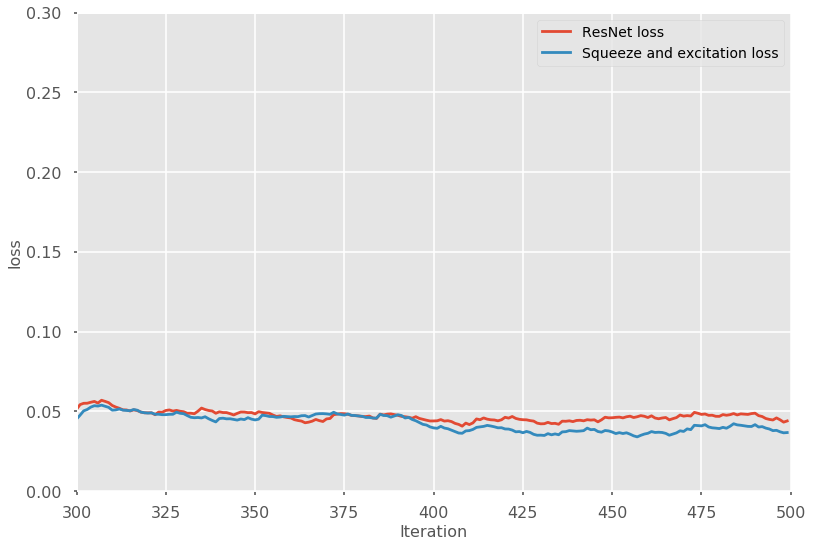

In [9]:
utils.draw(ResNet_loss, 'ResNet', SE_loss, 'Squeeze and excitation', window=50, bound=[300, 500, 0, 0.3])

It's clearer now that squeeze and excitation block on average gives better quality than simple ResNet. And SE ResNet has approximately the same number of parameters:
* SE ResNet - 23994378
* classic ResNet - 23495690.

While SE blocks have been empirically shown to improve network performance, let's understand how the self-gating excitation mechanism operates in practice. To provide a clearer picture of the behavior of SE blocks, we will draw the values of activations from our SE ResNet and examine their distribution with respect to different classes. In this case, the distribution is the difference between the activation values for examples with different classes.

In [10]:
def get_maps(graph, ppl, sess):
    operations = graph.get_operations()
    head_operations = [oper for oper in operations if 'head' in oper.name]
    oper_name = head_operations[1].name + ':0'

    next_batch = ppl.next_batch()
    maps = sess.run(oper_name, 
                    feed_dict={
                        'ResNet/inputs/images:0': next_batch.images, 
                        'ResNet/inputs/labels:0': next_batch.labels,
                        'ResNet/globals/is_training:0': False
                    })

    return maps, next_batch.labels

Loading our maps and answers

In [11]:
res_sess = res_test_ppl.get_model_by_name("resnet").session
res_graph = res_sess.graph

se_sess = se_test_ppl.get_model_by_name('se_block').session
se_graph = se_sess.graph

res_maps, res_answers = get_maps(res_graph, res_test_ppl, res_sess)
se_maps, se_answers = get_maps(se_graph, se_test_ppl, se_sess)

Draw a plot of the distribution of card activations after GAP for individual classes. Each line is the distribution of one class.

In [12]:
def draw_avgpooling(maps, answers, model=True):
    import seaborn as sns
    from pandas import ewma
    col = sns.color_palette("Set2", 8) + sns.color_palette(["#9b59b6", "#3498db"])

    indices = np.array([np.where(answers == i)[0] for i in range(10)])

    filters = np.array([np.mean(maps[indices[i]], axis=0).reshape(-1) for i in range(10)])
    for i in range(10):
        plt.plot(ewma(filters[i], span=350, adjust=False), color=col[i], label=str(i))

    plt.title("Distribution of average pooling in "+("SE ResNet" if model else 'simple ResNet'))
    plt.legend(fontsize=16, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel('Activation value', fontsize=18)
    plt.xlabel('Future map index', fontsize=18)
    plt.axis([0, 2060, 0., 1.])
    plt.show()


/home/anton/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.


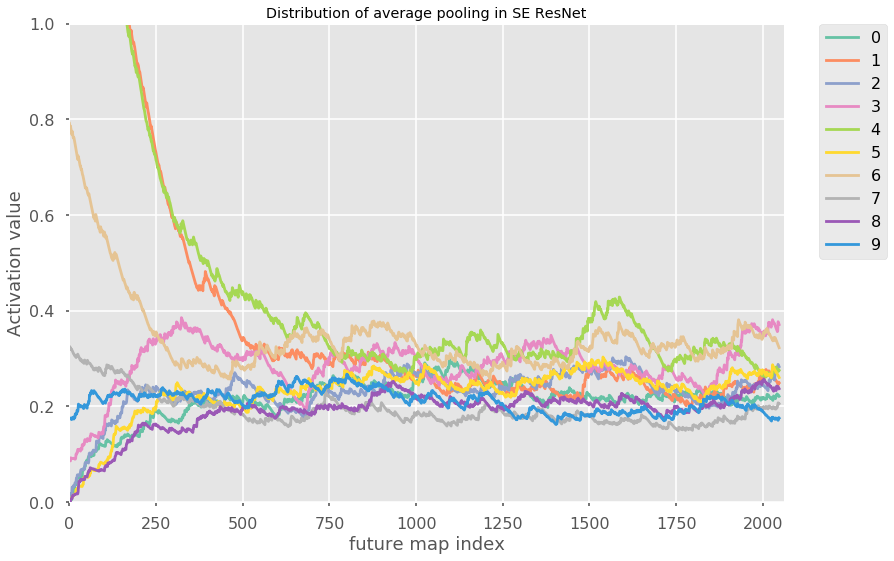

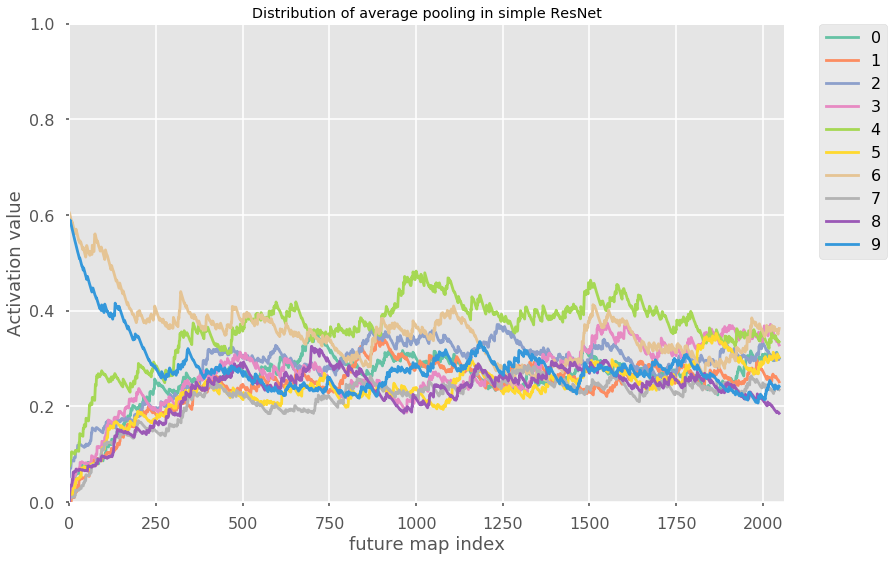

In [13]:
draw_avgpooling(se_maps, se_answers)
draw_avgpooling(res_maps, res_answers, False)

On the first picture there are future maps, depending on the class, the activation values vary greatly. In the second picture, this behavior is not observed and the activation value in each future map is practically independent of the class of the object.

## Conclusion:
* Squeeze and excitation block gives better quality than simple ResNet with almost the same number of parameters.
* The distribution of SE ResNet maps is wider than that of a simple ResNet.

## And what's next?
* Squeeze and excitation block can be used not only in ResNet. You can embed it yourself in your favorite network and see how it will affect the quality.
* If you want to know more about BatchFlow library take a look at [the tutorials](./../../tutorial/00_description.ipynb).
* Read and apply another experiments:
    * [FreezeOut](./../freezeout/FreezeOut.ipynb)
    * [Stochastic Depth](./../stochastic_depth/stochastic_depth.ipynb)
    * or choose one from [the list of experiments](./../experiments.ipynb).
